## Assignment: Image recognition
- Alumno 1: Alex Ferroni
- Alumno 2: Vittorio Alberto Gianfrate
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [13]:
!pip install rasterio

In [14]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [16]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [17]:
import warnings
import rasterio
import numpy as np
import os

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    base_path = '/kaggle/input/datasets/vittoriogianfrate/recognition/xview_recognition/'
    
    src_raster = rasterio.open(base_path + filename, 'r')
    # --------------------

    # RasterIO to OpenCV
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img /255.0

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [18]:
import json
import os

json_file = '/kaggle/input/datasets/vittoriogianfrate/recognition/xview_recognition/xview_ann_train.json'
if not os.path.exists(json_file):
    json_file = '/kaggle/input/datasets/vittoriogianfrate/recognition/xview_recognition/xview_ann_train.json'
print(f"Caricamento annotazioni da: {json_file}")

with open(json_file) as ifs:
    json_data = json.load(ifs)
    
print("Annotazioni caricate con successo!")

Caricamento annotazioni da: /kaggle/input/datasets/vittoriogianfrate/recognition/xview_recognition/xview_ann_train.json
Annotazioni caricate con successo!


In [19]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [20]:
from sklearn.model_selection import train_test_split
labels_list = [x.objects[0].category for x in anns]
anns_train, anns_valid = train_test_split(anns, test_size=0.2, random_state=1, shuffle=True,stratify=labels_list)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 14996
Number of validation images: 3750


In [21]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten

print('Load model')
model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))      
model.add(Activation('relu'))
model.add(Dense(128))      
model.add(Activation('relu'))
model.add(Dense(len(categories)))
model.add(Activation('softmax'))
model.summary()

Load model


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │   154,141,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 13)             │         1,677 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 13)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,832,397 (590.64 MB)

 Trainable params: 154,832,397 (590.64 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from sklearn.utils import class_weight
import numpy as np

train_labels = [ann.objects[0].category for ann in anns_train]
unique_classes = np.unique(train_labels)

weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_labels
)

name_to_id = {v: k for k, v in categories.items()}

alpha_array = np.ones(len(categories), dtype=np.float32)

for class_name, weight in zip(unique_classes, weights_values):
    if class_name in name_to_id:
        class_id = name_to_id[class_name]
        alpha_array[class_id] = weight
        print(f"Classe: {class_name:<20} ID: {class_id:<3} Peso: {weight:.4f}")

alpha_list = alpha_array.tolist()

print("\nLISTA DEFINITIVA PRONTA PER FOCAL LOSS:", alpha_list)

Classe: Building             ID: 8   Peso: 0.4012
Classe: Bus                  ID: 2   Peso: 0.8158
Classe: Cargo plane          ID: 0   Peso: 2.2707
Classe: Dump truck           ID: 6   Peso: 1.1664
Classe: Excavator            ID: 7   Peso: 1.8281
Classe: Fishing vessel       ID: 5   Peso: 2.0417
Classe: Helipad              ID: 9   Peso: 12.9611
Classe: Motorboat            ID: 4   Peso: 1.3492
Classe: Pylon                ID: 12  Peso: 4.6142
Classe: Shipping container   ID: 11  Peso: 0.9471
Classe: Small car            ID: 1   Peso: 0.4338
Classe: Storage tank         ID: 10  Peso: 0.9817
Classe: Truck                ID: 3   Peso: 0.6525

LISTA DEFINITIVA PRONTA PER FOCAL LOSS: [2.270745038986206, 0.43382418155670166, 0.8157980442047119, 0.6524538993835449, 1.349167823791504, 2.041661024093628, 1.1663684844970703, 1.8281116485595703, 0.4012307822704315, 12.961106300354004, 0.9817348718643188, 0.9470759034156799, 4.614153861999512]


In [23]:
from tensorflow.keras.optimizers import Adam

# Learning rate is changed to 0.001
opt = Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=3.0, alpha=alpha_list), metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=7, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=20, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [25]:
def generator_images(objs, batch_size, do_shuffle=False,class_weights=None):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels,weights = [], [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
                if class_weights is not None:
                    weights.append(class_weights[obj.category])
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            if class_weights is not None:
                weights = np.array(weights).astype(np.float32)
                yield images, labels, weights # <--- Restituisce 3 cose!
            else:
                yield images, labels

In [26]:
from sklearn.utils import class_weight
import numpy as np

# compute the weights based on train data
train_labels = [ann.objects[0].category for ann in anns_train]
unique_classes = np.unique(train_labels)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_labels
)

# Dictionare for Keras
class_weights_dict = dict(zip(unique_classes, weights))

In [27]:
import random
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

In [28]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 64
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [29]:
import math
import numpy as np

print('Training model')
epochs = 75
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/75


I0000 00:00:1771155135.358635     124 service.cc:152] XLA service 0x7c2bfc00e610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771155135.358709     124 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771155135.888232     124 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/235 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.0898 - loss: 2.9456

I0000 00:00:1771155137.792400     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1714 - loss: 1.9344
Epoch 1: val_accuracy improved from -inf to 0.30773, saving model to model.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 648s 3s/step - accuracy: 0.1716 - loss: 1.9334 - val_accuracy: 0.3077 - val_loss: 1.4188 - learning_rate: 5.0000e-05
Epoch 2/75
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.3083 - loss: 1.3692
Epoch 2: val_accuracy improved from 0.30773 to 0.35653, saving model to model.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 92s 394ms/step - accuracy: 0.3083 - loss: 1.3691 - val_accuracy: 0.3565 - val_loss: 1.3994 - learning_rate: 5.0000e-05
Epoch 3/75
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.3346 - loss: 1.3027
Epoch 3: val_accuracy did not improve from 0.35653
235/235 ━━━━━━━━━━━━━━━━━━━━ 80s 341ms/step - accuracy: 0.3346 - loss: 1.3025 - val_accuracy: 0.3093 - val_loss: 1.3941 - learning_rate: 5.0000e-05
Epoch 4/75
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3603 - loss: 1.2390
Epoc

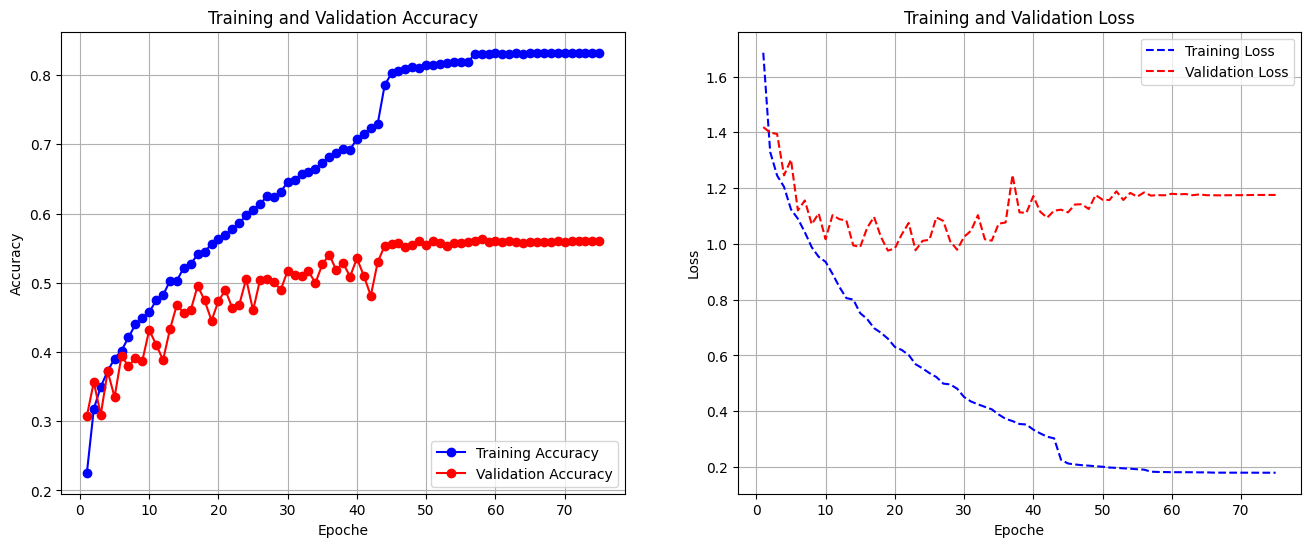

In [30]:
import matplotlib.pyplot as plt

def plot_results(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 6))

    # --- GRAFICO 1: ACCURACY
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoche')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # --- GRAFICO 2: LOSS 
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue', linestyle='--')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()


plot_results(h)

#### Validation
Compute validation metrics.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [32]:
import numpy as np

model.load_weights('model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

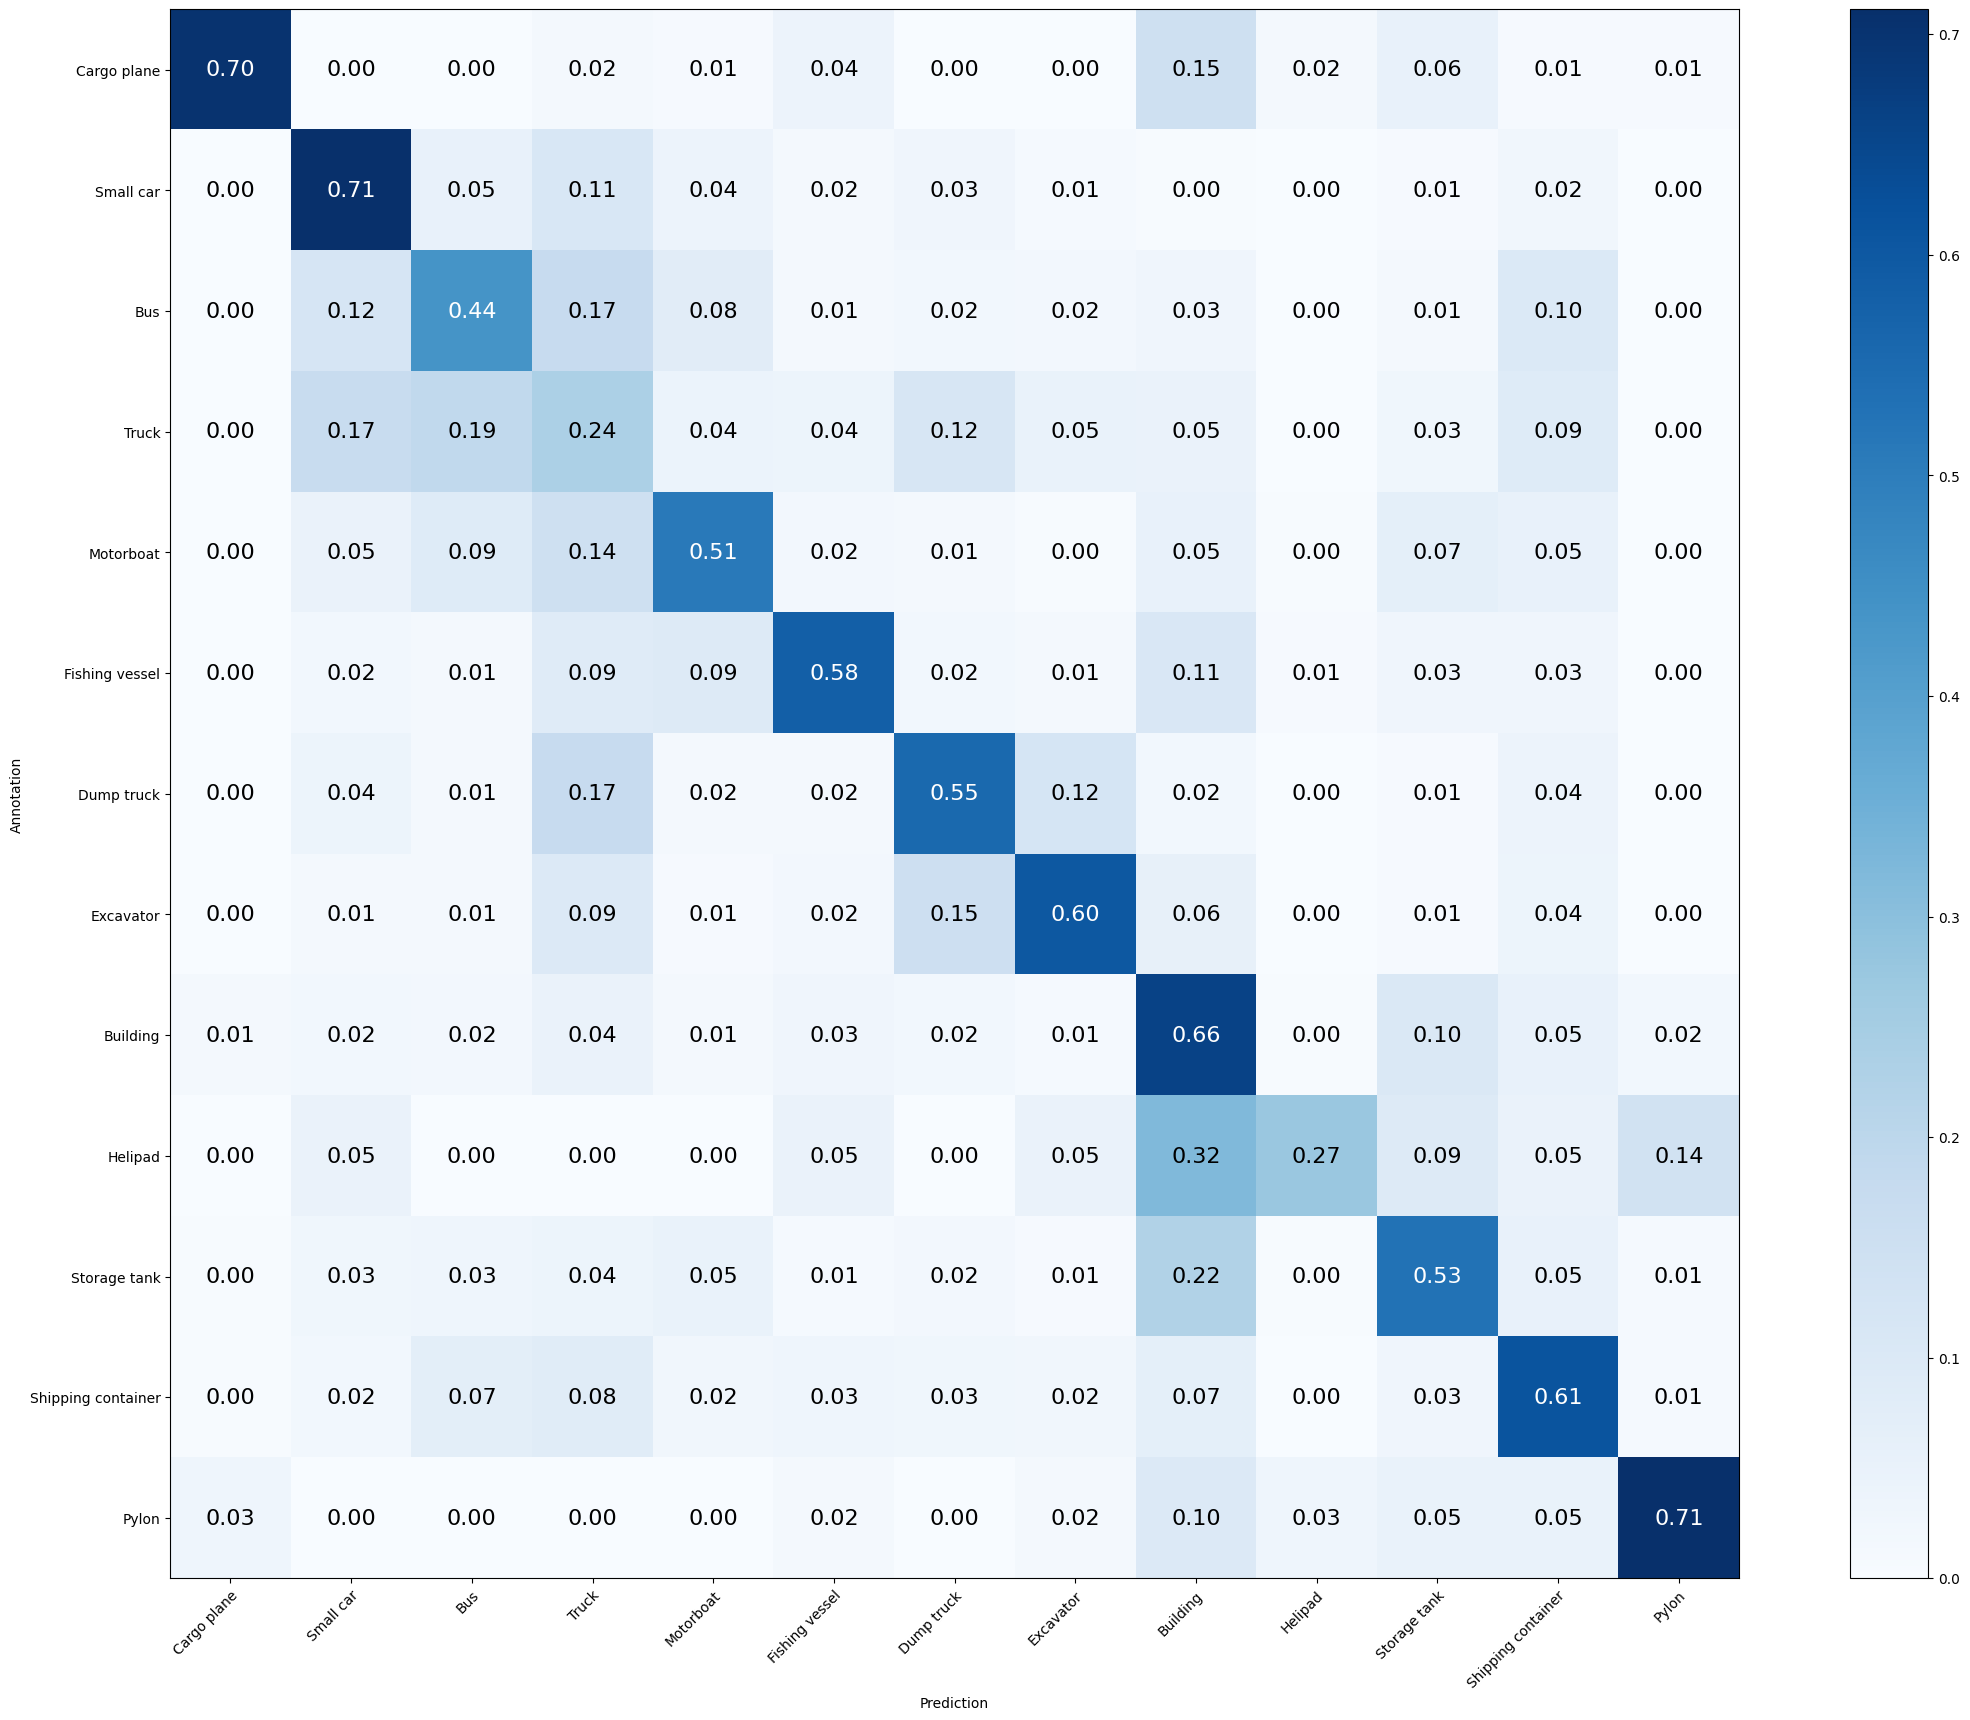

In [33]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [34]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 56.293%
Mean Recall: 54.749%
Mean Precision: 54.511%
> Cargo plane: Recall: 70.079% Precision: 86.408% Specificity: 99.614% Dice: 77.391%
> Small car: Recall: 71.128% Precision: 73.333% Specificity: 94.425% Dice: 72.214%
> Bus: Recall: 43.785% Precision: 45.190% Specificity: 94.464% Dice: 44.476%
> Truck: Recall: 23.529% Precision: 25.428% Specificity: 90.780% Dice: 24.442%
> Motorboat: Recall: 50.935% Precision: 46.983% Specificity: 96.521% Dice: 48.879%
> Fishing vessel: Recall: 58.156% Precision: 50.000% Specificity: 97.728% Dice: 53.770%
> Dump truck: Recall: 55.466% Precision: 50.554% Specificity: 96.175% Dice: 52.896%
> Excavator: Recall: 60.127% Precision: 53.073% Specificity: 97.661% Dice: 56.380%
> Building: Recall: 65.925% Precision: 71.278% Specificity: 93.698% Dice: 68.497%
> Helipad: Recall: 27.273% Precision: 37.500% Specificity: 99.732% Dice: 31.579%
> Storage tank: Recall: 53.061% Precision: 53.608% Specificity: 96.094% Dice: 53.333%
> Shipping container:

#### opt = Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=3.0, alpha=alpha_list), metrics=['accuracy'])Testing
Try to improve the results provided in the competition.

In [38]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk('/kaggle/input/datasets/vittoriogianfrate/recognition/xview_recognition/xview_test'):
    for filename in filenames:
        relative_path = os.path.join('xview_test', filename)
        image = GenericImage(relative_path)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [39]:
import numpy as np

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [40]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)